In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image


/Users/claudiadahinten/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df = pd.read_csv('Earthwatch_Data/df_modelling.csv')

In [3]:
df.columns

Index(['sample_date', 'site_name', 'fw_bodytype', 'land_use', 'water_flow',
       'water_level', 'nitrate', 'phosphate', 'latitude', 'longitude',
       'precipIntensityMax', 'continent', 'country', 'state', 'county', 'city',
       'town', 'village', 'city_proxy', 'town_proxy', 'village_proxy',
       'other_proxy', 'water_body_category', 'year', 'month', 'quarter',
       'algae_evenly', 'algae_attached', 'algae_floating', 'algae_scum',
       'algae_noalg', 'aqlife_frogs', 'aqlife_fish', 'aqlife_other',
       'aqlife_plantsemerge', 'aqlife_none', 'aqlife_plantsbelow',
       'aqlife_birds', 'aqlife_plantsfloat', 'watuse_swimming', 'watuse_other',
       'watuse_watersupply', 'watuse_irrigation', 'watuse_fishing',
       'watuse_boating', 'pol_industrial', 'pol_other', 'pol_residential',
       'pol_road', 'watsur_oily', 'watsur_litter', 'watsur_foam',
       'watsur_none', 'watsur_floatalg', 'bankveg_noveg', 'bankveg_trees',
       'bankveg_other', 'bankveg_grass'],
      dtype='o

In [4]:
#drop columns that are not relevant in modelling
df.drop(columns=['sample_date', 'site_name', 'latitude', 'longitude', 'country', 'state', 'county',
                'city', 'town', 'village', 'phosphate', 'year'], inplace = True)

In [5]:
#convert month and quarter into object as they are not neccesarily in order
df.month = df.month.astype(str)
df.quarter = df.quarter.astype(str)

In [6]:
df_dummies = pd.get_dummies(df, drop_first = True)

In [7]:
df_dummies.shape

(16037, 80)

## Classification Models

### Nitrate target and predictor variables

In [8]:
#create classification for nitrate (low, medium, high)
df['classify_nitrate'] = df.nitrate.apply(lambda x: 'low' if x < 0.5 else \
                                                  'medium' if (x >= 0.5 and x < 2) \
                                                  else 'high'
                                                 )

In [9]:
#skewed dataset - most observations are low
df['classify_nitrate'].value_counts()

low       8774
high      3669
medium    3594
Name: classify_nitrate, dtype: int64

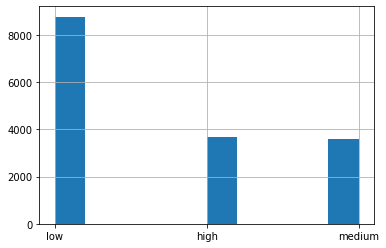

In [10]:
fig, ax = plt.subplots()
df.classify_nitrate.hist(ax = ax)
labels = ['low', 'medium', 'high']
ax.set_x_ticklabels = (df,['low','medium','high']);

In [11]:
# predictors without phosphate
X_nit = df_dummies.drop(columns = ['nitrate'])

In [12]:
# target
y_nit = df['classify_nitrate']

In [13]:
#baseline
y_nit.value_counts(normalize = True)

low       0.547110
high      0.228783
medium    0.224107
Name: classify_nitrate, dtype: float64

### Preprocessing

In [14]:
scaler = StandardScaler()
minmax = MinMaxScaler()
power = PowerTransformer()
poly = PolynomialFeatures(2, interaction_only = True)

## MODELS

- Try different preprocessing steps on various untuned models.
- There are very slight differences between Bagging and Random Forest, and choosing different random states gives different best models.
- Polynomial Features gives the best results, but takes too long to run, so I will not choose this as the preferred model
- I will choose <b> Random Forest with Standardisation 64.6% </b> as the best model to tune

 

### No Standardisation

In [15]:
def scoring(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, 
                                                        stratify = y, random_state = 1)
    
    fitted_model = model.fit(X_train, y_train)
    train = np.round(model.score(X_train, y_train), 3)
    test =  np.round(model.score(X_test, y_test), 3)
    cv = np.round(cross_val_score(model, X_train, y_train, cv = 5, n_jobs = 2).mean(), 3)
    
    return train, test, cv

In [16]:
models = {  
    
    'K-nearest': KNeighborsClassifier(),
    'Logistic': LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'auto', max_iter = 5000),
    'DecisionTree' : DecisionTreeClassifier(random_state=1, max_depth = 15),
    'RandomForest': RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 15),
    'Bagging': BaggingClassifier(random_state=1, n_estimators = 100),
    'AdaBoost': AdaBoostClassifier(random_state=1, n_estimators = 100),
    'GradBoost': GradientBoostingClassifier(random_state=1, n_estimators = 100),

}

initial_results = { k: scoring(X_nit, y_nit, v) for k, v in models.items() }

In [17]:
no_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                              1 : 'Test',
                                                              2 : 'CV'})

In [18]:
no_scaler

,Train,Test,CV
K-nearest,0.721,0.599,0.589
Logistic,0.610,0.601,0.603
DecisionTree,0.851,0.583,0.587
RandomForest,0.892,0.647,0.646
Bagging,0.996,0.643,0.643
AdaBoost,0.608,0.600,0.601
GradBoost,0.637,0.614,0.618


### Standard Scaler

In [19]:
def scoring_scaler(X, y, scaler, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, 
                                                        stratify = y, random_state = 1)
    
    pipe = Pipeline(steps = [('scaler', scaler), ('model', model)])
    
    fitted_model = pipe.fit(X_train, y_train)
    train = np.round(fitted_model.score(X_train, y_train), 3)
    test =  np.round(fitted_model.score(X_test, y_test), 3)
    cv = np.round(cross_val_score(fitted_model, X_train, y_train, cv = 5, n_jobs = 2).mean(), 3)
    
    return train, test, cv

In [20]:
initial_results = { k: scoring_scaler(X_nit, y_nit, scaler, v) for k, v in models.items() }

In [21]:

standard_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                                    1 : 'Test',
                                                                    2 : 'CV'})

In [22]:
standard_scaler

,Train,Test,CV
K-nearest,0.714,0.579,0.578
Logistic,0.609,0.601,0.603
DecisionTree,0.851,0.583,0.587
RandomForest,0.892,0.647,0.646
Bagging,0.996,0.643,0.643
AdaBoost,0.608,0.600,0.601
GradBoost,0.637,0.614,0.618


### Min Max

In [23]:
initial_results = { k: scoring_scaler(X_nit, y_nit, minmax, v) for k, v in models.items() }

In [24]:
minmax_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                                  1 : 'Test',
                                                                  2 : 'CV'})

In [25]:
minmax_scaler

,Train,Test,CV
K-nearest,0.720,0.595,0.590
Logistic,0.610,0.600,0.604
DecisionTree,0.851,0.583,0.587
RandomForest,0.892,0.647,0.646
Bagging,0.996,0.643,0.643
AdaBoost,0.608,0.600,0.601
GradBoost,0.637,0.614,0.618


## Best Model

### Gridsearch

In [26]:
#Random Forest

In [27]:
best_model = RandomForestClassifier(random_state=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_nit, y_nit, test_size = 0.2, shuffle = True,
                                                    stratify = y_nit, random_state = 1)
pipe = Pipeline(steps = [('scaler', scaler), ('model', best_model)])    


grid_param = {'model__n_estimators': [50, 100, 200, 500],
             'model__min_samples_split' : [2, 5, 10],
             }
grid = GridSearchCV(pipe, grid_param, cv = 5)
grid.fit(X_train, y_train)
print('Train score: ', grid.score(X_train, y_train))
print('Test score: ', grid.score(X_test, y_test))

#takes a long time to run
print('Cross val score: ', cross_val_score(grid, X_train, y_train, cv = 5).mean())

Train score:  0.9567386390209681
Test score:  0.6443266832917706
Cross val score:  0.6510242350485203


### Feature Importances

In [29]:
grid.classes_

array(['high', 'low', 'medium'], dtype=object)

In [30]:
feature_importances = np.mean([tree.feature_importances_ for tree in 
                               grid.best_estimator_.named_steps['model'].estimators_], axis=0)
pd.DataFrame({'features' : X_nit.columns,
             'importances' : feature_importances}).sort_values('importances', ascending = False)[:10]

,features,importances
64,water_body_category_Standing,0.042694
0,precipIntensityMax,0.041946
59,continent_Europe,0.036118
60,continent_North America,0.027204
49,water_flow_Still,0.022777
48,water_flow_Steady,0.020068
47,land_use_Urban Residential,0.019566
55,water_level_Low,0.019255
1,city_proxy,0.018865
38,fw_bodytype_Pond,0.018384


### Decision Tree Visualisation

Cannot visualise Random Forest decision tree, but can visualise one decision tree from the Random Forest

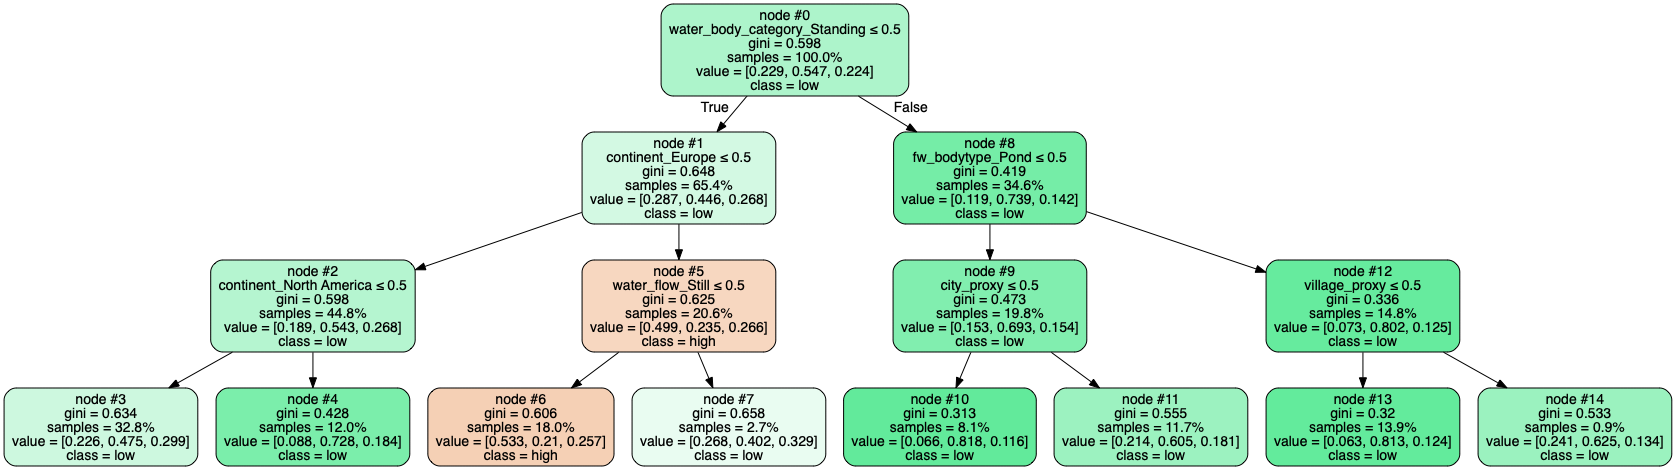

In [31]:
dt = DecisionTreeClassifier(
    max_depth=3, min_samples_split=2, random_state=1)
dt.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                feature_names=X_nit.columns,  
                class_names=dt.classes_,
                filled=True, rounded=True,
                proportion=True,
                special_characters=True,
                node_ids=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Evaluation

In [32]:
def evaluation(model, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print('Train Data')
    print('------------------------------------------------------------------------------------------------')
    conf_train = confusion_matrix(y_train, pred_train, labels = labels)
    print(pd.DataFrame(conf_train,columns = labels,index = labels))
    print(classification_report(y_train, pred_train))
    
    print('Test Data')
    print('------------------------------------------------------------------------------------------------')
    conf_test = confusion_matrix(y_test, pred_test, labels = labels)
    print(pd.DataFrame(conf_test,columns = labels,index = labels))
    print(classification_report(y_test, pred_test))

In [33]:
evaluation(grid, X_train, y_train, X_test, y_test)

Train Data
------------------------------------------------------------------------------------------------
         low  medium  high
low     6987      16    16
medium   281    2549    45
high     175      22  2738
              precision    recall  f1-score   support

        high       0.98      0.93      0.96      2935
         low       0.94      1.00      0.97      7019
      medium       0.99      0.89      0.93      2875

    accuracy                           0.96     12829
   macro avg       0.97      0.94      0.95     12829
weighted avg       0.96      0.96      0.96     12829

Test Data
------------------------------------------------------------------------------------------------
         low  medium  high
low     1524     102   129
medium   413     158   148
high     273      76   385
              precision    recall  f1-score   support

        high       0.58      0.52      0.55       734
         low       0.69      0.87      0.77      1755
      medium       0.47  

## Visualisation

### Set up Logistic Regression

The below investigates the most important features for the Logisitc Regression model.

In [34]:
model = LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'auto', max_iter = 5000)
X_train, X_test, y_train, y_test = train_test_split(X_nit, y_nit, test_size = 0.2, shuffle = True,
                                                    stratify = y_nit, random_state = 1)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
model.classes_

array(['high', 'low', 'medium'], dtype=object)

### Coefficients

In [36]:
#coefficients for high nitrate levels
coef_df = pd.DataFrame({'features': X_nit.columns,
                        'coef': model.coef_[0],
                        'abs_coef': np.abs(model.coef_[0])})

coef_df.sort_values('abs_coef', ascending = False)[:10]

,features,coef,abs_coef
59,continent_Europe,1.080322,1.080322
38,fw_bodytype_Pond,-0.920526,0.920526
51,water_level_Bottom,0.874166,0.874166
62,continent_South America,0.536822,0.536822
44,land_use_Industrial,0.481662,0.481662
56,water_level_Medium,0.473790,0.473790
57,water_level_Slow,0.441247,0.441247
1,city_proxy,0.428508,0.428508
49,water_flow_Still,-0.410048,0.410048
58,continent_Asia,0.385151,0.385151


### ROC Curve

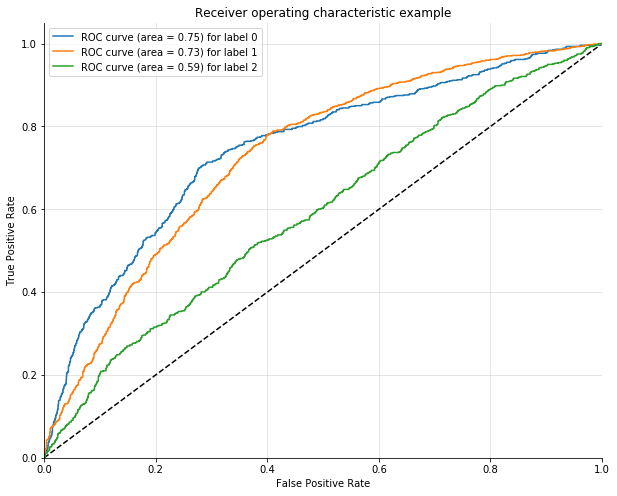

In [37]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model, X_test, y_test, n_classes=3, figsize=(10, 8))